In [1]:
import proposal as pp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14

In [2]:
N_SAMPLES = int(1e4)
pp.InterpolationSettings.tables_path = "/tmp" # save interpolation tables to folder

## Continuous randomization
The continuous randomization utility can apply fluctuations to continuous energy losses. This can be useful when high energy cuts or only continuous propagation is used, for example infront of the detector volume.

The fluctuations are sampled from a Gaussian distribution with the variance

$$ \sigma^2 = \int_{E_i}^{E_f} \frac{E^2}{-f(E)} \left\langle \frac{\mathrm{d}^2E}{\mathrm{d}x^2} \right\rangle
\mathrm{d}E  $$
with the average continuous energy loss $f(E)$, the initial energy $E_i$ and the final energy $E_f$.

*When executed for the first time, the following cell will take some time since interpolation tables are built*

In [3]:
args = {
    "particle_def": pp.particle.MuMinusDef(),
    "target": pp.medium.StandardRock(),
    "interpolate": True,
    "cuts": pp.EnergyCutSettings(500, 1, True)
}

cross = pp.crosssection.make_std_crosssection(**args)
contrand = pp.make_contrand(cross, True)

### Example 1
We assume a particle with a fixed initial energy $E_i$ and a fixed final energy $E_f$. We apply random fluctuations and show the resulting new final energies in a histogram:

Text(0, 0.5, 'counts')

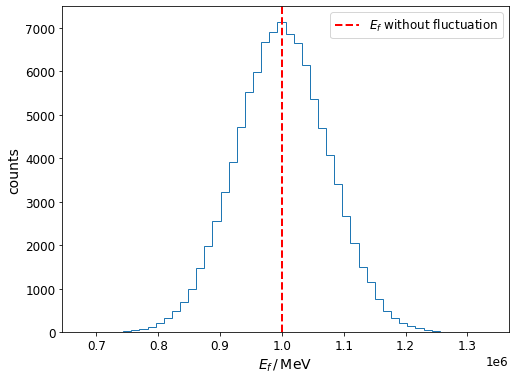

In [4]:
SAMPLE_SIZE = int(1e5)
E_i = 1e8
E_f = 1e6
E_f_fluc = []

for i in range(SAMPLE_SIZE):
    E_f_fluc.append(contrand.randomize(E_i, E_f, random.random()))

_ = plt.hist(E_f_fluc, bins=50, histtype="step")
plt.axvline(x = E_f, c='r', linestyle='--', label=r'$E_f$ without fluctuation')
plt.legend()
plt.xlabel(r'$E_{f} \,/\, \mathrm{MeV} $')
plt.ylabel("counts")

### Example 2
We take an example where the continuous energy loss is very small. We expect from our continuous randomization module that the fluctuated energy is always below the initial energy. Furthermore, we demand that our flucuations still follow a Gaussian curve with the calculated variance and $E_f$ as its mean. 
The following plot visualizes these properties:

In [5]:
initial_energy = 1e5
final_energy = 0.999e5
std = np.sqrt(contrand.variance(initial_energy, final_energy))
randomized_energies = contrand.randomize(
    np.full(N_SAMPLES, initial_energy), 
    np.full(N_SAMPLES, final_energy), 
    np.linspace(0,1,N_SAMPLES+2)[1:-1]
)

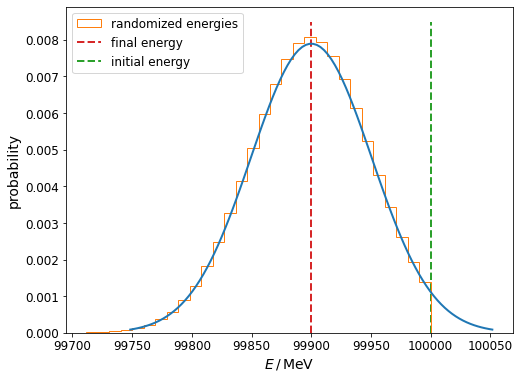

In [6]:
x = np.linspace(final_energy - 3*std, final_energy + 3*std, 100)
plt.plot(x, norm.pdf(x, final_energy, std))

n, _, _ = plt.hist(randomized_energies, bins = 30, histtype="step", density=True, label='randomized energies')

lines_args = {"ymin": 0, "ymax": 1.05*np.max(n), "linestyle":"dashed"}
plt.vlines(final_energy, colors="C3", label="final energy", **lines_args)
plt.vlines(initial_energy, colors="C2", label="initial energy", **lines_args)
plt.xlabel(r'$E \,/\, \mathrm{MeV} $')
plt.ylabel('probability')
plt.legend(loc="best")